In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import os,sys
sys.path.insert(0,"..")
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import sys
import torch.nn.functional as F
import pandas as pd

In [2]:
import torch
import torch.nn as nn
from functools import partial
from torch.hub import load_state_dict_from_url

import timm.models.vision_transformer as vit
import timm.models.swin_transformer as swin
from convnext import ConvNeXt
# import timm.models.efficientnet as effinet
 
from timm.models.helpers import load_state_dict

from utils import remap_pretrained_keys_swin

class OmniSwinTransformer(swin.SwinTransformer):
    def __init__(self, num_classes_list, projector_features = None, use_mlp=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert num_classes_list is not None
        
        self.projector = None 
        if projector_features:
            encoder_features = self.num_features
            self.num_features = projector_features
            if use_mlp:
                self.projector = nn.Sequential(nn.Linear(encoder_features, self.num_features), nn.ReLU(inplace=True), nn.Linear(self.num_features, self.num_features))
            else:
                self.projector = nn.Linear(encoder_features, self.num_features)

        self.omni_heads = []
        for num_classes in num_classes_list:
            self.omni_heads.append(nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity())
        self.omni_heads = nn.ModuleList(self.omni_heads)

    def forward(self, x, head_n=None):
        x = self.forward_features(x)
        if self.projector:
            x = self.projector(x)
        if head_n is not None:
            return x, self.omni_heads[head_n](x)
        else:
            return [head(x) for head in self.omni_heads]
    
    def generate_embeddings(self, x, after_proj = True):
        x = self.forward_features(x)
        if after_proj:
            x = self.projector(x)
        return x
    
num_classes_list = [14,14,14,3,6,1]
pretrained_weights = "../Ark6_swinLarge768_ep50.pth.tar"
key = "teacher"

input_size = 768
model = OmniSwinTransformer(num_classes_list, projector_features=1376, use_mlp=False, img_size = input_size, patch_size=4, window_size=12, embed_dim=192, depths=(2, 2, 18, 2), num_heads=(6, 12, 24, 48))
checkpoint = torch.load(pretrained_weights, map_location=torch.device('cpu'))
state_dict = checkpoint[key]
if any([True if 'module.' in k else False for k in state_dict.keys()]):
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items() if k.startswith('module.')}       
# k_del = []
# for k in state_dict.keys():
#     if "attn_mask" in k:
#         k_del.append(k)
# print(f"Removing key {k_del} from pretrained checkpoint")
# for k in k_del:
#     del state_dict[k]
    
msg = model.load_state_dict(state_dict, strict=False)
print('Loaded with msg: {}'.format(msg))  



/home/dongaoma/miniconda3/envs/MG/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loaded with msg: <All keys matched successfully>


In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import SimpleITK as sitk
import numpy as np
from tqdm import tqdm
import pydicom as dicom

class Node21(Dataset):
    def __init__(self, data_path, exclude = []): #["jsrt", "openi", "padchest", "chestxray14"]
        exclude_img_id = []
        source_df = pd.read_csv("/mnt/dfs/jpang12/datasets/NODE21/cxr_images/original_data/filenames_orig_and_new.csv")
        for s in exclude:
            sdf = source_df[source_df['orig_dataset'] == s]
            exclude_img_id.extend(sdf['node21_img_id'].tolist())
        
        img_dir = os.path.join(data_path)
        self.img_list = []
        self.img_label = []
        for fname in os.listdir(img_dir):
            if fname.endswith('.png') and fname.split('.')[0] not in exclude_img_id:
                img_path = os.path.join(img_dir, fname)
                label = 1 if "n" == fname[0] else 0
                label = np.array(label, dtype='float32')
                self.img_list.append(img_path)
                self.img_label.append(label)
        print(np.sum(self.img_label))
    
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        imagePath = self.img_list[index]
        imageLabel = torch.FloatTensor(self.img_label[index])
        imageData = sitk.ReadImage(imagePath) 
        image_array = sitk.GetArrayFromImage(imageData)
        imageData = Image.fromarray(image_array).convert('RGB').resize((input_size,input_size))
        image = np.array(imageData) / 255.
        mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        image = (image - mean)/std
        image = image.transpose(2, 0, 1).astype('float32')
        return image, imageLabel, imagePath

class SIIM_PTX_all(Dataset):
    def __init__(self, data_path, train_file, test_file):    
        super().__init__()
        
        self.data_list = []
        self.labels = []  
        with open(train_file, "r") as fileDescriptor:
            line = True
            while line:
                line = fileDescriptor.readline()
                if line:
                    lineItems = line.split()
                    dataPath = os.path.join(data_path, "train", lineItems[0]+'.dcm')
                    label = [int(lineItems[1])]
                    self.data_list.append(dataPath)
                    self.labels.append(label)
 
        with open(test_file, "r") as fileDescriptor:
            line = fileDescriptor.readline()
            while line:
                line = fileDescriptor.readline()
                if line:
                    lineItems = line.split()
                    dataPath = os.path.join(data_path, "test", lineItems[0]+'.dcm')
                    label = [int(lineItems[1])]
                    self.data_list.append(dataPath)
                    self.labels.append(label)     
        
        print('#data: ', len(self.data_list))  
    
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        imagePath = self.data_list[index]
        imageLabel = torch.FloatTensor(self.labels[index])
        im_array = dicom.dcmread(imagePath).pixel_array
        imageData = Image.fromarray(im_array).convert('RGB').resize((input_size,input_size))
        image = np.array(imageData) / 255.
        mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        image = (image - mean)/std
        image = image.transpose(2, 0, 1).astype('float32')
        return image, imageLabel, imagePath

In [10]:
device = "cuda:0"
ds_name = "Node21"
img_path = "/mnt/dfs/dongaoma/dataset/NODE21_original_png/"
diseases = "Nodule"
ds = Node21(img_path)

dataloader = DataLoader(ds, 1, shuffle=False, num_workers=1)

1134.0


In [11]:
model.to(device)
embeddings = torch.FloatTensor().to(device)
# predictions = torch.FloatTensor().to(device)
labels = torch.FloatTensor().to(device)
fname_list = []
with torch.no_grad():
    for i, (samples, targets, fnames) in enumerate(tqdm(dataloader)):
        samples, targets = samples.float().to(device), targets.float().to(device)
#         pre_logits = model(samples)
#         preds = [torch.sigmoid(out) for out in pre_logits]
#         preds = torch.cat(preds, dim=1)
#         predictions = torch.cat((predictions, preds), dim=0)  
        embed = model.generate_embeddings(samples) 
        embeddings = torch.cat((embeddings, embed), 0)
        labels = torch.cat((labels, targets), dim=0)
        fname_list.extend(fnames)
    embeddings = embeddings.cpu().numpy()    
#     predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()
    print(embeddings.shape)
    print(labels.shape)
    print(len(fname_list))

100%|██████████| 4882/4882 [3:03:10<00:00,  2.25s/it]  


(4882, 1376)
(4882,)
4882


In [12]:
path = "/mnt/dfs/dongaoma/dataset/Embeddings/ark6_swinL768_node21o_2304"
for i, fname in enumerate(tqdm(fname_list)):
        im_name = fname.replace('/mnt/dfs/dongaoma/dataset/NODE21_original_png/', '')
        #dir_list.remove('')
        
        if not os.path.exists(path):
            os.makedirs(path)

        data = np.array(embeddings[i]).astype(np.float32)
        #print(np.shape(data))
        np.save(os.path.join(path,im_name.replace('.png','.npy')), data)
        #data = np.load(os.path.join(path,im_name.replace(args.suffix,'.npy')))
        #print(np.shape(data))

100%|██████████| 4882/4882 [00:08<00:00, 591.90it/s]


In [9]:
model.to(device)
#embeddings = torch.FloatTensor().to(device)
predictions = torch.FloatTensor().to(device)
labels = torch.FloatTensor().to(device)
fname_list = []
with torch.no_grad():
    for i, (samples, targets, fnames) in enumerate(dataloader):
        samples, targets = samples.float().to(device), targets.float().to(device)
        pre_logits = model(samples)
        preds = [torch.sigmoid(out) for out in pre_logits]
        preds = torch.cat(preds, dim=1)
        predictions = torch.cat((predictions, preds), dim=0)  
#         embed = model.generate_embeddings(samples) 
#         embeddings = torch.cat((embeddings, embed), 0)
        labels = torch.cat((labels, targets), dim=0)
        fname_list.extend(fnames)
#     embeddings = embeddings.cpu().numpy()    
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()
#     print(embeddings.shape)
    print(labels.shape)
    print(len(fname_list))

(4882,)
4882


In [10]:
mimic_diseases = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
chexpert_diseases = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
nih14_diseases = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
rsna_diseases = ['No Lung Opacity/Not Normal', 'Normal', 'Lung Opacity']
vindr_diseases = ['PE', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other diseases', 'No finding']
shenzhen_diseases = ['TB']
disease_list = mimic_diseases + chexpert_diseases + nih14_diseases + rsna_diseases + vindr_diseases + shenzhen_diseases
print(disease_list)

['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices', 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Lung Opacity/Not Normal', 'Normal', 'Lung Opacity', 'PE', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other diseases', 'No finding', 'TB']


In [11]:
df = pd.DataFrame(predictions, columns = disease_list)
df.insert(loc = len(df.columns), column = ds_name, value = labels)
df.to_csv("Ark6_SwinL768_Nodule21processed_all_ZeroShotPred.csv")

In [12]:
df = pd.read_csv("Ark6_SwinL768_Nodule21processed_all_ZeroShotPred.csv")
df
# 4882: 2/4/10 
#Randomly sampling
#99.96% Google 80%/20% 

,Unnamed: 0,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,...,Normal,Lung Opacity.2,PE,Lung tumor,Pneumonia.3,Tuberculosis,Other diseases,No finding,TB,Node21
0,0,0.007017,0.002687,0.004831,0.001404,0.006381,0.068302,0.006975,0.021278,0.882135,...,0.018578,0.003042,0.001154,0.000649,0.000397,0.001594,0.004378,0.997947,0.467606,0.0
1,1,0.006261,0.004295,0.008043,0.007532,0.007801,0.029904,0.018570,0.036713,0.814652,...,0.051793,0.003468,0.004403,0.001525,0.001075,0.007631,0.021176,0.982382,0.883749,0.0
2,2,0.057508,0.011834,0.019043,0.050614,0.030173,0.029714,0.015192,0.162183,0.435224,...,0.197043,0.011592,0.006265,0.002030,0.006555,0.009141,0.039579,0.976622,0.384014,0.0
3,3,0.150088,0.095622,0.032766,0.149860,0.053315,0.019154,0.009036,0.225865,0.374703,...,0.720137,0.017922,0.004766,0.002070,0.017997,0.010933,0.398497,0.675301,0.363650,0.0
4,4,0.009838,0.007021,0.004559,0.006208,0.008111,0.022789,0.006220,0.027576,0.855306,...,0.037010,0.001812,0.000859,0.000556,0.000246,0.000645,0.005681,0.997609,0.396430,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4877,4877,0.029778,0.015027,0.005836,0.006161,0.021054,0.039135,0.006131,0.032632,0.756217,...,0.114835,0.005476,0.008854,0.001287,0.003792,0.005370,0.093872,0.929261,0.515307,0.0
4878,4878,0.039601,0.030587,0.018411,0.034072,0.016211,0.025893,0.716633,0.238367,0.243708,...,0.981056,0.004319,0.070311,0.174038,0.024897,0.128384,0.943044,0.013972,0.999280,1.0
4879,4879,0.046725,0.026506,0.016762,0.022558,0.020790,0.027113,0.029149,0.089676,0.581118,...,0.510090,0.025026,0.138440,0.005565,0.013455,0.055023,0.532884,0.383562,0.987676,1.0
4880,4880,0.033633,0.012815,0.022837,0.052359,0.016698,0.019381,0.029933,0.199254,0.489031,...,0.350568,0.002514,0.004378,0.002575,0.003137,0.024936,0.016189,0.990984,0.912391,0.0


In [100]:
df.keys()

Index(['Unnamed: 0', 'No Finding', 'Enlarged Cardiomediastinum',
       'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation',
       'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
       'Pleural Other', 'Fracture', 'Support Devices', 'No Finding.1',
       'Enlarged Cardiomediastinum.1', 'Cardiomegaly.1', 'Lung Opacity.1',
       'Lung Lesion.1', 'Edema.1', 'Consolidation.1', 'Pneumonia.1',
       'Atelectasis.1', 'Pneumothorax.1', 'Pleural Effusion.1',
       'Pleural Other.1', 'Fracture.1', 'Support Devices.1', 'Atelectasis.2',
       'Cardiomegaly.2', 'Effusion', 'Infiltration', 'Mass', 'Nodule',
       'Pneumonia.2', 'Pneumothorax.2', 'Consolidation.2', 'Edema.2',
       'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia',
       'No Lung Opacity/Not Normal', 'Normal', 'Lung Opacity.2', 'PE',
       'Lung tumor', 'Pneumonia.3', 'Tuberculosis', 'Other diseases',
       'No finding', 'TB', 'Node21'],
      dtype='object')

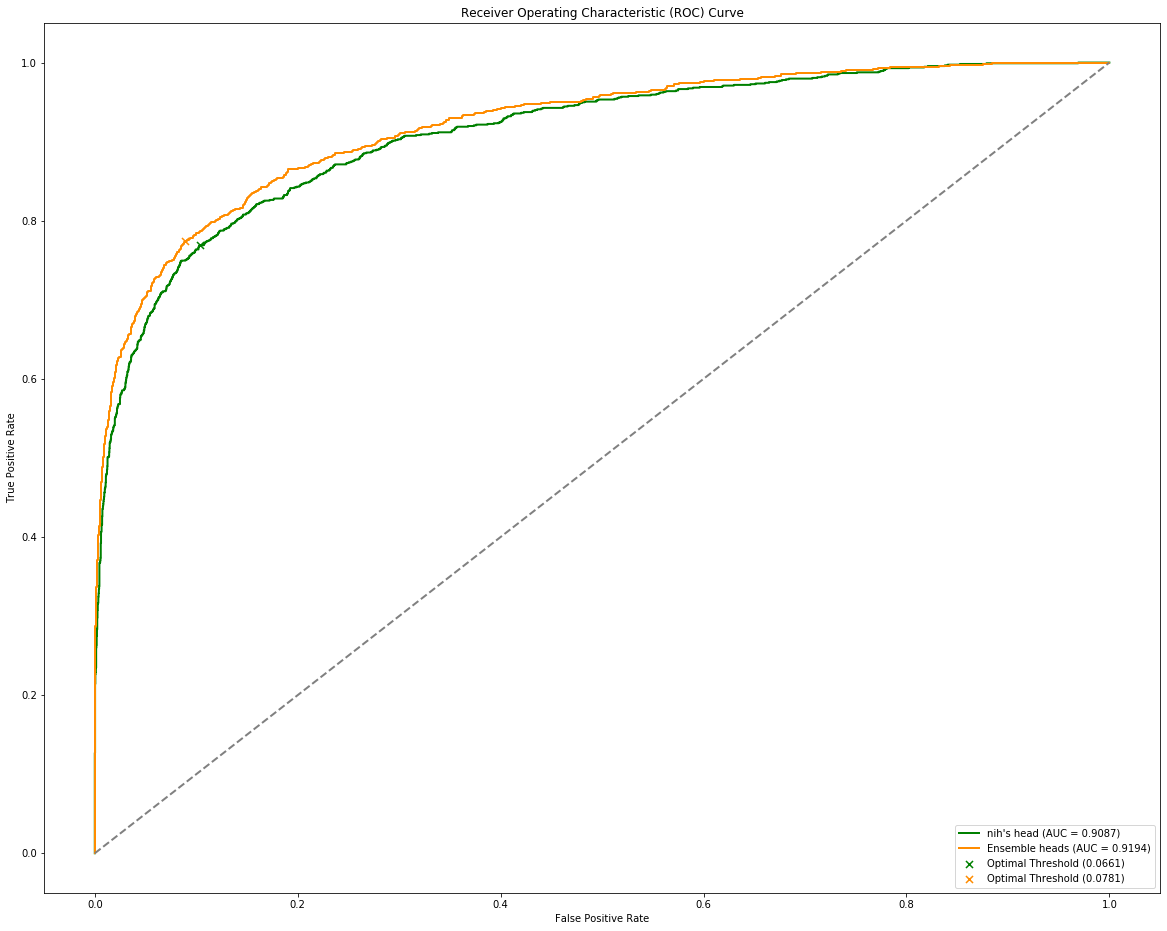

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have true labels (y_true) and predicted probabilities (y_scores)
# y_true should be binary (0 or 1), and y_scores should be predicted probabilities of being in class 1
df = pd.read_csv("Ark6_SwinL768_Nodule21processed_all_ZeroShotPred.csv")
y_true = np.array(df['Node21'])
y_scores = np.array(df['Nodule'])
#y_scores = np.average((np.array(df['Nodule']),np.array(df['Mass']),np.array(df['Lung tumor'])), axis = 0)
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

y_scores2 = np.average((np.array(df['Nodule']),np.array(df['Mass']),np.array(df['Lung tumor'])), axis = 0)
#y_scores2 = np.array(df['Lung tumor'])
fpr2, tpr2, _ = roc_curve(y_true, y_scores2)
roc_auc2 = auc(fpr2, tpr2)#
optimal_threshold_index2 = np.argmax(tpr2 - fpr2)
optimal_threshold2 = thresholds[optimal_threshold_index2]


# y_scores3 = np.average((np.array(df['TB']),np.array(df['Tuberculosis'])), axis = 0)
# fpr3, tpr3, _ = roc_curve(y_true, y_scores3)
# roc_auc3 = auc(fpr3, tpr3)
# optimal_threshold_index3 = np.argmax(tpr3 - fpr3)
# optimal_threshold3 = thresholds[optimal_threshold_index3]

# Plotting
plt.figure(figsize=(20, 16))
plt.plot(fpr, tpr, color='green', lw=2, label='nih\'s head (AUC = {:.4f})'.format(roc_auc))
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label='Ensemble heads (AUC = {:.4f})'.format(roc_auc2))
# plt.plot(fpr3, tpr3, color='navy', lw=2, label='Ensemble head (AUC = {:.4f})'.format(roc_auc3))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], color='green', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold:.4f})')
plt.scatter(fpr2[optimal_threshold_index2], tpr2[optimal_threshold_index2], color='darkorange', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold2:.4f})')
# plt.scatter(fpr3[optimal_threshold_index3], tpr3[optimal_threshold_index3], color='navy', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold3:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Optimal Threshold: 0.02777087166666667


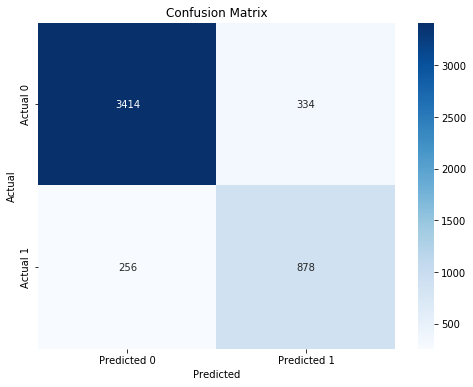

AUROC: 0.9087
Accuracy: 0.8791
Precision: 0.7244
Recall (Sensitivity): 0.7743
F1 Score: 0.7485
False Positive Rate (FPR): 0.0891
False Negative Rate (FNR): 0.2257


In [14]:
import numpy as np
from sklearn.metrics import roc_curve

# Assuming you have true labels (y_true) and predicted probabilities (y_scores)
# y_true should be binary (0 or 1), and y_scores should be predicted probabilities of being in class 1
y_true = np.array(df['Node21'])
y_scores = np.average((np.array(df['Nodule']),np.array(df['Mass']),np.array(df['Lung tumor'])), axis = 0)
# y_scores = np.array(df['Tuberculosis'])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculate Youden's J statistic for each threshold
youden_j = tpr - fpr

# Find the optimal threshold
optimal_threshold = thresholds[np.argmax(youden_j)]

print("Optimal Threshold:", optimal_threshold)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# y_true and y_pred should be arrays with the same length containing the actual and predicted labels respectively
y_pred = (y_scores >= optimal_threshold).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics
TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

# Metrics calculations
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
FPR = FP / (FP + TN)  # False Positive Rate
FNR = FN / (FN + TP)  # False Negative Rate

# Print metrics
print(f'AUROC: {roc_auc:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')
print(f'False Positive Rate (FPR): {FPR:.4f}')
print(f'False Negative Rate (FNR): {FNR:.4f}')

In [20]:
device = "cuda:0"
ds_name = "Node21"
img_path = "/mnt/dfs/dongaoma/dataset/NODE21_processed_png/"
diseases = "Nodule"
ds = Node21(img_path, exclude = ["chestxray14"])

dataloader = DataLoader(ds, 1, shuffle=False, num_workers=4)
model.to(device)
#embeddings = torch.FloatTensor().to(device)
predictions = torch.FloatTensor().to(device)
labels = torch.FloatTensor().to(device)
fname_list = []
with torch.no_grad():
    for i, (samples, targets, fnames) in enumerate(tqdm(dataloader)):
        samples, targets = samples.float().to(device), targets.float().to(device)
        pre_logits = model(samples)
        preds = [torch.sigmoid(out) for out in pre_logits]
        preds = torch.cat(preds, dim=1)
        predictions = torch.cat((predictions, preds), dim=0)  
#         embed = model.generate_embeddings(samples) 
#         embeddings = torch.cat((embeddings, embed), 0)
        labels = torch.cat((labels, targets), dim=0)
        fname_list.extend(fnames)
#     embeddings = embeddings.cpu().numpy()    
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()
#     print(embeddings.shape)
    print(labels.shape)
    print(len(fname_list))


517.0


100%|██████████| 4265/4265 [17:30<00:00,  4.00it/s]


(4265,)
4265


In [21]:
df = pd.DataFrame(predictions, columns = disease_list)
df.insert(loc = len(df.columns), column = ds_name, value = labels)
df.to_csv("Ark6_SwinL768_Nodule21processed_excludeNIH_ZeroShotPred.csv")

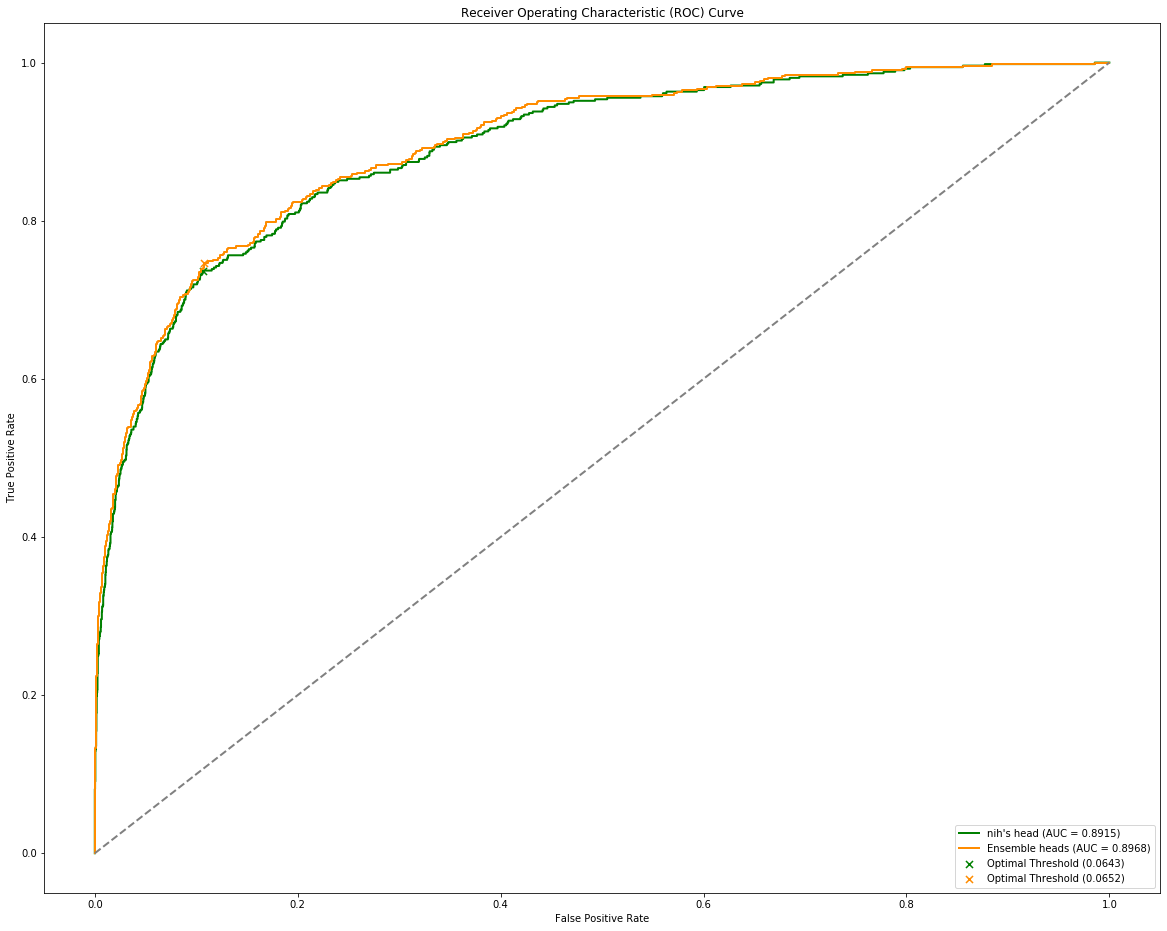

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have true labels (y_true) and predicted probabilities (y_scores)
# y_true should be binary (0 or 1), and y_scores should be predicted probabilities of being in class 1
df = pd.read_csv("Ark6_SwinL768_Nodule21processed_excludeNIH_ZeroShotPred.csv")
y_true = np.array(df['Node21'])
y_scores = np.array(df['Nodule'])
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

y_scores2 = np.average((np.array(df['Nodule']),np.array(df['Mass']),np.array(df['Lung tumor'])), axis = 0)
fpr2, tpr2, _ = roc_curve(y_true, y_scores2)
roc_auc2 = auc(fpr2, tpr2)
optimal_threshold_index2 = np.argmax(tpr2 - fpr2)
optimal_threshold2 = thresholds[optimal_threshold_index2]


# y_scores3 = np.average((np.array(df['TB']),np.array(df['Tuberculosis'])), axis = 0)
# fpr3, tpr3, _ = roc_curve(y_true, y_scores3)
# roc_auc3 = auc(fpr3, tpr3)
# optimal_threshold_index3 = np.argmax(tpr3 - fpr3)
# optimal_threshold3 = thresholds[optimal_threshold_index3]

# Plotting
plt.figure(figsize=(20, 16))
plt.plot(fpr, tpr, color='green', lw=2, label='nih\'s head (AUC = {:.4f})'.format(roc_auc))
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label='Ensemble heads (AUC = {:.4f})'.format(roc_auc2))
# plt.plot(fpr3, tpr3, color='navy', lw=2, label='Ensemble head (AUC = {:.4f})'.format(roc_auc3))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], color='green', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold:.4f})')
plt.scatter(fpr2[optimal_threshold_index2], tpr2[optimal_threshold_index2], color='darkorange', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold2:.4f})')
# plt.scatter(fpr3[optimal_threshold_index3], tpr3[optimal_threshold_index3], color='navy', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold3:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve

# Assuming you have true labels (y_true) and predicted probabilities (y_scores)
# y_true should be binary (0 or 1), and y_scores should be predicted probabilities of being in class 1
y_true = np.array(df['Node21'])
# y_scores = np.average((np.array(df['Nodule']),np.array(df['Mass']),np.array(df['Lung tumor'])), axis = 0)
y_scores = np.array(df['Nodule'])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculate Youden's J statistic for each threshold
youden_j = tpr - fpr

# Find the optimal threshold
optimal_threshold = thresholds[np.argmax(youden_j)]

print("Optimal Threshold:", optimal_threshold)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# y_true and y_pred should be arrays with the same length containing the actual and predicted labels respectively
y_pred = (y_scores >= optimal_threshold).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics
TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

# Metrics calculations
roc_auc = auc(fpr, tpr)
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
FPR = FP / (FP + TN)  # False Positive Rate
FNR = FN / (FN + TP)  # False Negative Rate

# Print metrics
print(f'AUROC: {roc_auc:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')
print(f'False Positive Rate (FPR): {FPR:.4f}')
print(f'False Negative Rate (FNR): {FNR:.4f}')

Optimal Threshold: 0.06426164


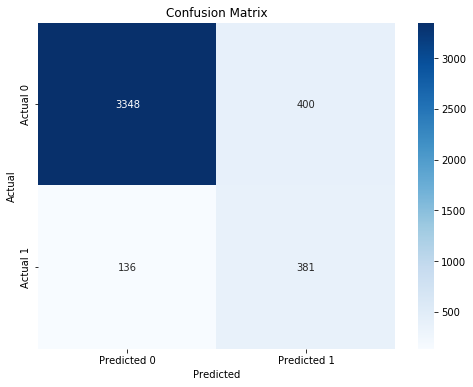

AUROC: 0.8915
Accuracy: 0.8743
Precision: 0.4878
Recall (Sensitivity): 0.7369
F1 Score: 0.5871
False Positive Rate (FPR): 0.1067
False Negative Rate (FNR): 0.2631


In [6]:
import numpy as np
from sklearn.metrics import roc_curve

# Assuming you have true labels (y_true) and predicted probabilities (y_scores)
# y_true should be binary (0 or 1), and y_scores should be predicted probabilities of being in class 1
y_true = np.array(df['Node21'])
y_scores = np.array(df['Nodule'])
# y_scores = np.array(df['Tuberculosis'])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculate Youden's J statistic for each threshold
youden_j = tpr - fpr

# Find the optimal threshold
optimal_threshold = thresholds[np.argmax(youden_j)]

print("Optimal Threshold:", optimal_threshold)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# y_true and y_pred should be arrays with the same length containing the actual and predicted labels respectively
y_pred = (y_scores >= optimal_threshold).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics
TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

# Metrics calculations
roc_auc = auc(fpr, tpr)
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
FPR = FP / (FP + TN)  # False Positive Rate
FNR = FN / (FN + TP)  # False Negative Rate

# Print metrics
print(f'AUROC: {roc_auc:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')
print(f'False Positive Rate (FPR): {FPR:.4f}')
print(f'False Negative Rate (FNR): {FNR:.4f}')

In [24]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
# import pandas as pd
import numpy as np
# import pytorch_lightning as pl

# from pytorch_lightning.loggers import TensorBoardLogger
# from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm import tqdm
# from argparse import ArgumentParser

class TBX11K(Dataset):
    def __init__(self, img_dir, classes = ["tb", "health"]):
        self.img_list = []
        self.img_label = []
        for folder in classes:
            for fname in os.listdir(os.path.join(img_dir, folder)):
                if fname.endswith('.png'):
                    img_path = os.path.join(img_dir, folder, fname)
                    label = 1 if "tb" in fname else 0
                    label = np.array(label, dtype='float32')
                    self.img_list.append(img_path)
                    self.img_label.append(label)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        imagePath = self.img_list[index]
        imageLabel = torch.FloatTensor(self.img_label[index])
        imageData = Image.open(imagePath).convert('RGB').resize((input_size,input_size))
        image = np.array(imageData) / 255.
        mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        image = (image - mean)/std
        image = image.transpose(2, 0, 1).astype('float32')
        return image, imageLabel


class MontgomeryTB(Dataset):
    def __init__(self, img_dir):
        self.data = os.listdir(img_dir)
        self.img_list = []
        self.img_label = []
        for fname in self.data:
            if fname.endswith('.png'):
                img_path = os.path.join(img_dir, fname)
                label = np.array(fname[-5], dtype='float32')
                self.img_list.append(img_path)
                self.img_label.append(label)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        imagePath = self.img_list[index]
        imageLabel = torch.FloatTensor(self.img_label[index])
        imageData = Image.open(imagePath).convert('RGB').resize((input_size,input_size))
        image = np.array(imageData) / 255.
        mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        image = (image - mean)/std
        image = image.transpose(2, 0, 1).astype('float32')
        return image, imageLabel
    
class MontgomeryTB_emb(Dataset):
    def __init__(self, emb_path, diseases, ds_name = ""):
        self.data = os.listdir(emb_path)
        self.diseases = diseases
        self.samples = []
        for idx, _ in enumerate(tqdm(range(len(self.data)), desc='Loading Data')):
            img_path = self.data[idx]
            img_label = np.zeros(len(self.diseases), dtype='float32')
            for i in range(0, len(self.diseases)):
                img_label[i] = np.array(self.data[idx][-5], dtype='float32')
#             print(self.data[idx], self.data[idx][-5])
#             img_path = self.data.loc[idx, 'path']
#             img_label = np.zeros(len(self.labels), dtype='float32')
#             for i in range(0, len(self.labels)):
#                 img_label[i] = np.array(self.data.loc[idx, self.labels[i].strip()] == 1, dtype='float32')

            sample = {'image_path': img_path, 'label': img_label}
            self.samples.append(sample)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        sample = self.get_sample(item)

        features = torch.from_numpy(sample['features'])
        label = torch.from_numpy(sample['label'])
        #print(features.size())
        return {'features': features, 'label': label}

    def get_sample(self, item):
        sample = self.samples[item]
        img_fn = sample['image_path']
        feat_fn = os.path.join(data_dir, img_fn)

        features = np.load(feat_fn)#.astype(np.float32)

        return {'features': features, 'label': sample['label']}

In [25]:
device = "cpu"
ds_name = "MontgomeryTB"
# emd_path = "/mnt/dfs/dongaoma/dataset/Embeddings/ark6_orgT_Montgomery/Montgomery/"
img_path = "/mnt/dfs/jpang12/datasets/MontgomeryCountyX-ray/MontgomerySet/CXR_png/"
diseases = "TB"
ds = MontgomeryTB(img_path)

dataloader = DataLoader(ds, 4, shuffle=False, num_workers=4)

model.to(device)
predictions = torch.FloatTensor().to(device)
labels = torch.FloatTensor().to(device)
with torch.no_grad():
    for i, (samples, targets) in enumerate(dataloader):
        samples, targets = samples.float().to(device), targets.float().to(device)
        pre_logits = model(samples)
        preds = [torch.sigmoid(out) for out in pre_logits]
        preds = torch.cat(preds, dim=1)
        predictions = torch.cat((predictions, preds), dim=0)
    
        labels = torch.cat((labels, targets), dim=0)
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()
    print(predictions.shape)
    print(labels.shape)

(138, 52)
(138,)


In [26]:
mimic_diseases = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
chexpert_diseases = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
nih14_diseases = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
rsna_diseases = ['No Lung Opacity/Not Normal', 'Normal', 'Lung Opacity']
vindr_diseases = ['PE', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other diseases', 'No finding']
shenzhen_diseases = ['TB']
disease_list = mimic_diseases + chexpert_diseases + nih14_diseases + rsna_diseases + vindr_diseases + shenzhen_diseases
print(disease_list)

df = pd.DataFrame(predictions, columns = disease_list)
df.insert(loc = len(df.columns), column = ds_name, value = labels)
df.to_csv("Ark6_swinL768_MontgomeryTB_ZeroShotPred.csv")
df

['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices', 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Lung Opacity/Not Normal', 'Normal', 'Lung Opacity', 'PE', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other diseases', 'No finding', 'TB']


,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,...,Normal,Lung Opacity,PE,Lung tumor,Pneumonia,Tuberculosis,Other diseases,No finding,TB,MontgomeryTB
0,0.063922,0.076907,0.069386,0.013468,0.075725,0.006488,0.345729,0.457972,0.178559,0.016059,...,0.737514,0.078972,0.018446,0.076020,0.085501,0.901924,0.747933,0.026000,0.997831,1.0
1,0.010661,0.049023,0.004044,0.003114,0.012215,0.008801,0.003747,0.021903,0.842923,0.006072,...,0.013501,0.006182,0.000491,0.000400,0.000503,0.001891,0.001626,0.999081,0.027998,0.0
2,0.019354,0.046423,0.008852,0.005283,0.048301,0.007041,0.011592,0.060060,0.737407,0.010133,...,0.018678,0.006079,0.001226,0.001168,0.001236,0.003190,0.010133,0.994033,0.121332,0.0
3,0.014332,0.023904,0.004803,0.004527,0.023417,0.007405,0.005106,0.040974,0.868858,0.003022,...,0.022098,0.003367,0.000206,0.000436,0.000525,0.000773,0.008197,0.995681,0.025355,0.0
4,0.405397,0.566387,0.073291,0.532084,0.044274,0.025832,0.030656,0.319381,0.018287,0.947239,...,0.813332,0.301489,0.971419,0.013304,0.487337,0.080742,0.992341,0.001092,0.993585,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0.031462,0.037141,0.054465,0.021060,0.035752,0.012733,0.070581,0.458071,0.297283,0.071201,...,0.539101,0.091353,0.328348,0.006366,0.070286,0.983522,0.782672,0.035795,0.998971,1.0
134,0.109341,0.066438,0.194800,0.112740,0.081262,0.001728,0.409850,0.598468,0.025924,0.754897,...,0.611971,0.505577,0.875436,0.041519,0.812745,0.969298,0.602699,0.004802,0.999983,1.0
135,0.011685,0.031957,0.004018,0.002057,0.027597,0.010515,0.007313,0.027904,0.849167,0.005807,...,0.011821,0.002234,0.000702,0.000676,0.000717,0.001033,0.005903,0.996775,0.031122,0.0
136,0.013609,0.077401,0.005623,0.005171,0.053201,0.034462,0.009423,0.041851,0.653061,0.063964,...,0.039697,0.002484,0.022057,0.001481,0.001675,0.007115,0.033394,0.978511,0.097851,0.0


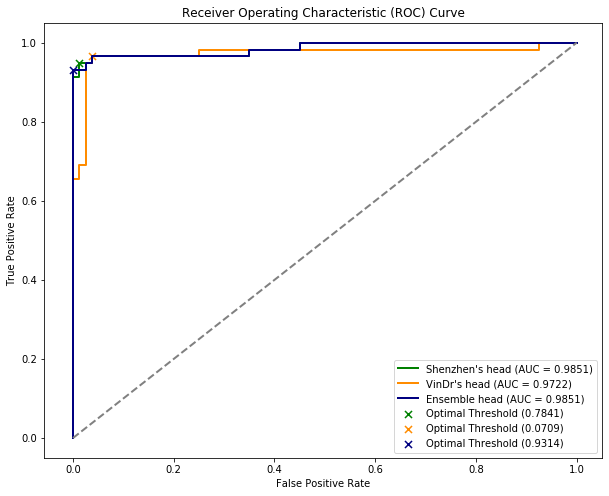

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have true labels (y_true) and predicted probabilities (y_scores)
# y_true should be binary (0 or 1), and y_scores should be predicted probabilities of being in class 1
df = pd.read_csv("Ark6_swinL768_MontgomeryTB_ZeroShotPred.csv")
y_true = np.array(df['MontgomeryTB'])
y_scores = np.array(df['TB'])
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

y_scores2 = np.array(df['Tuberculosis'])
fpr2, tpr2, _ = roc_curve(y_true, y_scores2)
roc_auc2 = auc(fpr2, tpr2)
optimal_threshold_index2 = np.argmax(tpr2 - fpr2)
optimal_threshold2 = thresholds[optimal_threshold_index2]


y_scores3 = np.average((np.array(df['TB']),np.array(df['Tuberculosis'])), axis = 0)
fpr3, tpr3, _ = roc_curve(y_true, y_scores3)
roc_auc3 = auc(fpr3, tpr3)
optimal_threshold_index3 = np.argmax(tpr3 - fpr3)
optimal_threshold3 = thresholds[optimal_threshold_index3]

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='green', lw=2, label='Shenzhen\'s head (AUC = {:.4f})'.format(roc_auc))
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label='VinDr\'s head (AUC = {:.4f})'.format(roc_auc2))
plt.plot(fpr3, tpr3, color='navy', lw=2, label='Ensemble head (AUC = {:.4f})'.format(roc_auc3))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], color='green', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold:.4f})')
plt.scatter(fpr2[optimal_threshold_index2], tpr2[optimal_threshold_index2], color='darkorange', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold2:.4f})')
plt.scatter(fpr3[optimal_threshold_index3], tpr3[optimal_threshold_index3], color='navy', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold3:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [28]:
device = "cuda:0"
ds_name = "TBX-11K"
img_path = "/mnt/dfs/jpang12/datasets/tbx11k/TBX11K/imgs/"
ds = TBX11K(img_path)
dataloader = DataLoader(ds, 4, shuffle=False, num_workers=4)

model.to(device)
predictions = torch.FloatTensor().to(device)
labels = torch.FloatTensor().to(device)
with torch.no_grad():
    for i, (samples, targets) in enumerate(dataloader):
        samples, targets = samples.float().to(device), targets.float().to(device)
        pre_logits = model(samples)
        preds = [torch.sigmoid(out) for out in pre_logits]
        preds = torch.cat(preds, dim=1)
        predictions = torch.cat((predictions, preds), dim=0)
    
        labels = torch.cat((labels, targets), dim=0)
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()
    print(predictions.shape)
    print(labels.shape)

(4600, 52)
(4600,)


In [29]:
mimic_diseases = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
chexpert_diseases = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
nih14_diseases = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
rsna_diseases = ['No Lung Opacity/Not Normal', 'Normal', 'Lung Opacity']
vindr_diseases = ['PE', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other diseases', 'No finding']
shenzhen_diseases = ['TB']
disease_list = mimic_diseases + chexpert_diseases + nih14_diseases + rsna_diseases + vindr_diseases + shenzhen_diseases

df = pd.DataFrame(predictions, columns = disease_list)
df.insert(loc = len(df.columns), column = ds_name, value = labels)
df.to_csv("Ark6_swinL768_TBX11K_ZeroShotPred.csv")
df

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,...,Normal,Lung Opacity,PE,Lung tumor,Pneumonia,Tuberculosis,Other diseases,No finding,TB,TBX-11K
0,0.026974,0.017663,0.039388,0.003484,0.030857,0.007395,0.207297,0.306089,0.240058,0.026041,...,0.617027,0.026895,0.177773,0.041292,0.038771,0.757260,0.846292,0.030621,0.999374,1.0
1,0.078523,0.098374,0.128524,0.013221,0.095438,0.008270,0.165273,0.566031,0.148833,0.057015,...,0.788770,0.149768,0.223584,0.026925,0.135124,0.978216,0.978051,0.000907,0.999829,1.0
2,0.027715,0.006395,0.051840,0.005926,0.017635,0.009942,0.206349,0.531706,0.216356,0.006424,...,0.626019,0.085773,0.029853,0.013505,0.086874,0.833433,0.709900,0.072594,0.999242,1.0
3,0.075187,0.016517,0.015983,0.031166,0.005986,0.017970,0.005195,0.207451,0.577658,0.011057,...,0.117343,0.095329,0.004058,0.001696,0.017983,0.002924,0.028777,0.983398,0.340296,1.0
4,0.009999,0.028953,0.038637,0.039654,0.032554,0.010680,0.077655,0.424781,0.362195,0.021785,...,0.618276,0.148634,0.182249,0.007591,0.389804,0.989117,0.922112,0.001226,0.999921,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,0.019535,0.048736,0.002995,0.000953,0.016651,0.035249,0.003255,0.021864,0.876607,0.005289,...,0.016082,0.002632,0.000786,0.000191,0.000418,0.000380,0.007741,0.996455,0.035308,0.0
4596,0.008880,0.004324,0.003498,0.000892,0.015707,0.029339,0.005946,0.023212,0.910591,0.005953,...,0.009901,0.000822,0.000784,0.000315,0.000219,0.000826,0.003231,0.998708,0.201420,0.0
4597,0.017174,0.005737,0.007657,0.002586,0.008869,0.008478,0.003615,0.072054,0.837737,0.005828,...,0.042658,0.004458,0.000426,0.000142,0.000238,0.000573,0.001853,0.999254,0.430423,0.0
4598,0.043457,0.049568,0.008307,0.002494,0.016329,0.035316,0.009063,0.065209,0.813373,0.005781,...,0.036492,0.008698,0.000633,0.000655,0.001630,0.001432,0.022159,0.988292,0.052382,0.0


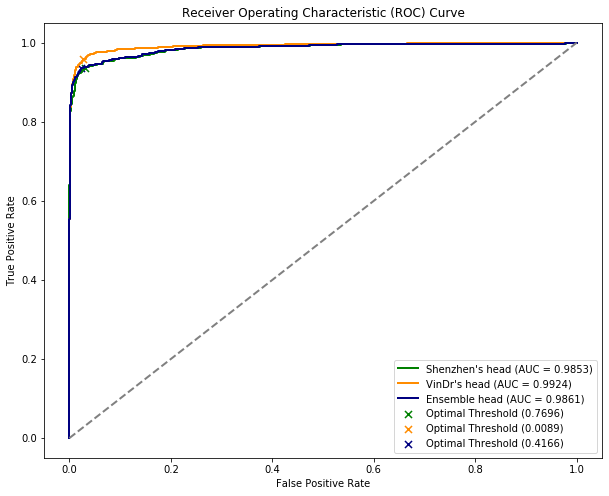

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have true labels (y_true) and predicted probabilities (y_scores)
# y_true should be binary (0 or 1), and y_scores should be predicted probabilities of being in class 1
df = pd.read_csv("Ark6_swinL768_TBX11K_ZeroShotPred.csv")
y_true = np.array(df['TBX-11K'])
y_scores = np.array(df['TB'])
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

y_scores2 = np.array(df['Tuberculosis'])
fpr2, tpr2, thresholds = roc_curve(y_true, y_scores2)
roc_auc2 = auc(fpr2, tpr2)
optimal_threshold_index2 = np.argmax(tpr2 - fpr2)
optimal_threshold2 = thresholds[optimal_threshold_index2]


y_scores3 = np.average((np.array(df['TB']),np.array(df['Tuberculosis'])), axis = 0)
fpr3, tpr3,thresholds = roc_curve(y_true, y_scores3)
roc_auc3 = auc(fpr3, tpr3)
optimal_threshold_index3 = np.argmax(tpr3 - fpr3)
optimal_threshold3 = thresholds[optimal_threshold_index3]

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='green', lw=2, label='Shenzhen\'s head (AUC = {:.4f})'.format(roc_auc))
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label='VinDr\'s head (AUC = {:.4f})'.format(roc_auc2))
plt.plot(fpr3, tpr3, color='navy', lw=2, label='Ensemble head (AUC = {:.4f})'.format(roc_auc3))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], color='green', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold:.4f})')
plt.scatter(fpr2[optimal_threshold_index2], tpr2[optimal_threshold_index2], color='darkorange', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold2:.4f})')
plt.scatter(fpr3[optimal_threshold_index3], tpr3[optimal_threshold_index3], color='navy', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold3:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [31]:
device = "cuda:0"
ds_name = "TBX-11K"
img_path = "/mnt/dfs/jpang12/datasets/tbx11k/TBX11K/imgs/"
ds = TBX11K(img_path, classes = ["tb", "sick", "health"])
dataloader = DataLoader(ds, 4, shuffle=False, num_workers=4)

# model.to(device)
predictions = torch.FloatTensor().to(device)
labels = torch.FloatTensor().to(device)
with torch.no_grad():
    for i, (samples, targets) in enumerate(dataloader):
        samples, targets = samples.float().to(device), targets.float().to(device)
        pre_logits = model(samples)
        preds = [torch.sigmoid(out) for out in pre_logits]
        preds = torch.cat(preds, dim=1)
        predictions = torch.cat((predictions, preds), dim=0)
    
        labels = torch.cat((labels, targets), dim=0)
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()
    print(predictions.shape)
    print(labels.shape)

(8400, 52)
(8400,)


In [32]:
mimic_diseases = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
chexpert_diseases = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
nih14_diseases = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
rsna_diseases = ['No Lung Opacity/Not Normal', 'Normal', 'Lung Opacity']
vindr_diseases = ['PE', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other diseases', 'No finding']
shenzhen_diseases = ['TB']
disease_list = mimic_diseases + chexpert_diseases + nih14_diseases + rsna_diseases + vindr_diseases + shenzhen_diseases

df = pd.DataFrame(predictions, columns = disease_list)
df.insert(loc = len(df.columns), column = ds_name, value = labels)
df.to_csv("Ark6_swinL768_TBX11K_TBvsSickHealth_ZeroShotPred.csv")
df

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,...,Normal,Lung Opacity,PE,Lung tumor,Pneumonia,Tuberculosis,Other diseases,No finding,TB,TBX-11K
0,0.023472,0.022271,0.030291,0.004448,0.027557,0.010878,0.179441,0.250688,0.233344,0.035201,...,0.591780,0.024162,0.213075,0.029468,0.030081,0.627696,0.813268,0.042561,0.999333,1.0
1,0.045558,0.081868,0.128410,0.012514,0.088025,0.007287,0.168748,0.568189,0.165068,0.043142,...,0.753391,0.158210,0.188471,0.016961,0.129915,0.981851,0.964274,0.001387,0.999851,1.0
2,0.024408,0.005247,0.052245,0.011148,0.018919,0.007093,0.174616,0.587294,0.310451,0.006691,...,0.427010,0.080406,0.018165,0.009837,0.073953,0.586787,0.378957,0.345452,0.997239,1.0
3,0.051484,0.034505,0.020051,0.045330,0.014885,0.021620,0.007824,0.224204,0.538831,0.012582,...,0.094890,0.065437,0.007140,0.002420,0.022629,0.005642,0.052480,0.967776,0.268069,1.0
4,0.012110,0.034954,0.046473,0.047231,0.038186,0.013613,0.075894,0.396707,0.359882,0.023182,...,0.636378,0.135956,0.156519,0.010643,0.311824,0.990131,0.876690,0.002017,0.999883,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,0.026377,0.042726,0.003255,0.001008,0.015245,0.037111,0.003400,0.024961,0.872033,0.006053,...,0.018579,0.003491,0.000965,0.000194,0.000489,0.000383,0.009505,0.995797,0.039500,0.0
8396,0.007992,0.008052,0.004459,0.001073,0.018891,0.045746,0.008055,0.024722,0.879035,0.006160,...,0.007818,0.001223,0.001597,0.000819,0.000381,0.001304,0.002368,0.999129,0.170245,0.0
8397,0.013112,0.009592,0.005846,0.003875,0.007974,0.008061,0.003460,0.051132,0.850425,0.004986,...,0.054108,0.003712,0.000300,0.000149,0.000181,0.000536,0.001470,0.999395,0.427091,0.0
8398,0.047073,0.060629,0.007098,0.002411,0.018896,0.019957,0.006633,0.073401,0.733248,0.002349,...,0.034647,0.015977,0.000506,0.001126,0.002816,0.001376,0.059285,0.970443,0.041295,0.0


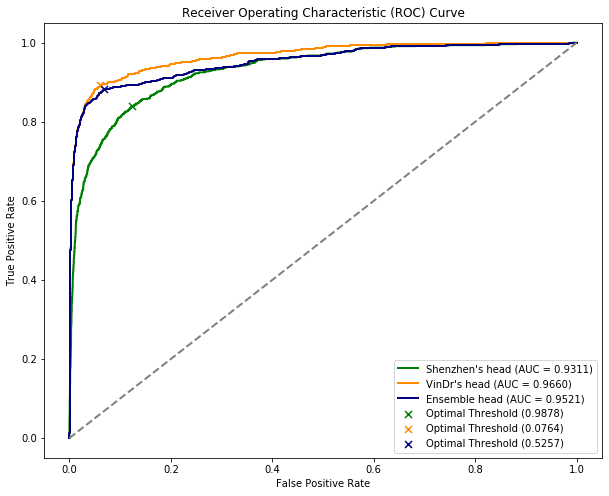

In [33]:
df = pd.DataFrame(predictions, columns = disease_list)
df.insert(loc = len(df.columns), column = ds_name, value = labels)
y_true = np.array(df['TBX-11K'])
y_scores = np.array(df['TB'])
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

y_scores2 = np.array(df['Tuberculosis'])
fpr2, tpr2, thresholds = roc_curve(y_true, y_scores2)
roc_auc2 = auc(fpr2, tpr2)
optimal_threshold_index2 = np.argmax(tpr2 - fpr2)
optimal_threshold2 = thresholds[optimal_threshold_index2]


y_scores3 = np.average((np.array(df['TB']),np.array(df['Tuberculosis'])), axis = 0)
fpr3, tpr3,thresholds = roc_curve(y_true, y_scores3)
roc_auc3 = auc(fpr3, tpr3)
optimal_threshold_index3 = np.argmax(tpr3 - fpr3)
optimal_threshold3 = thresholds[optimal_threshold_index3]

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='green', lw=2, label='Shenzhen\'s head (AUC = {:.4f})'.format(roc_auc))
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label='VinDr\'s head (AUC = {:.4f})'.format(roc_auc2))
plt.plot(fpr3, tpr3, color='navy', lw=2, label='Ensemble head (AUC = {:.4f})'.format(roc_auc3))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], color='green', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold:.4f})')
plt.scatter(fpr2[optimal_threshold_index2], tpr2[optimal_threshold_index2], color='darkorange', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold2:.4f})')
plt.scatter(fpr3[optimal_threshold_index3], tpr3[optimal_threshold_index3], color='navy', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold3:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [6]:
device = "cuda:1"
ds_name = "SIIMPTX"
img_path = "/mnt/dfs/jpang12/datasets/Pneumothorax_segmentation/"
diseases = "Pneumothorax"
ds = SIIM_PTX_all(img_path, train_file="../fewshot_eval/data/SIIMPTX_train_cls.txt", test_file="../fewshot_eval/data/SIIMPTX_test_cls.txt")

dataloader = DataLoader(ds, 4, shuffle=False, num_workers=1)

#data:  12046


In [7]:
model.to(device)
predictions = torch.FloatTensor().to(device)
labels = torch.FloatTensor().to(device)
with torch.no_grad():
    for i, (samples, targets, _) in enumerate(tqdm(dataloader)):
        samples, targets = samples.float().to(device), targets.float().to(device)
        pre_logits = model(samples)
        preds = [torch.sigmoid(out) for out in pre_logits]
        preds = torch.cat(preds, dim=1)
        predictions = torch.cat((predictions, preds), dim=0)
    
        labels = torch.cat((labels, targets), dim=0)
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()
    print(predictions.shape)
    print(labels.shape)

100%|██████████| 3012/3012 [51:33<00:00,  1.01s/it]


(12046, 52)
(12046, 1)


In [8]:
mimic_diseases = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
chexpert_diseases = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
nih14_diseases = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
rsna_diseases = ['No Lung Opacity/Not Normal', 'Normal', 'Lung Opacity']
vindr_diseases = ['PE', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other diseases', 'No finding']
shenzhen_diseases = ['TB']
disease_list = mimic_diseases + chexpert_diseases + nih14_diseases + rsna_diseases + vindr_diseases + shenzhen_diseases

df = pd.DataFrame(predictions, columns = disease_list)
df.insert(loc = len(df.columns), column = ds_name, value = labels)
df.to_csv("Ark6_swinL768_SIIM_Pneumothorax_ZeroShotPred.csv")
df

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,...,Normal,Lung Opacity,PE,Lung tumor,Pneumonia,Tuberculosis,Other diseases,No finding,TB,SIIMPTX
0,0.413120,0.079874,0.040160,0.008627,0.079836,0.028741,0.132710,0.174786,0.133266,0.466792,...,0.991853,0.009366,0.905270,0.015662,0.192354,0.225900,0.996101,0.000590,0.999391,0.0
1,0.161266,0.016603,0.055764,0.007694,0.016535,0.012253,0.011242,0.483922,0.256332,0.011555,...,0.110644,0.095139,0.003277,0.001599,0.036790,0.001069,0.042108,0.982021,0.171403,0.0
2,0.003793,0.028423,0.002336,0.001193,0.020367,0.014097,0.009325,0.007543,0.882315,0.010838,...,0.029664,0.001792,0.014814,0.003810,0.001798,0.004125,0.191861,0.850933,0.254683,0.0
3,0.025230,0.013883,0.007277,0.006478,0.019877,0.035284,0.026013,0.137216,0.663785,0.045413,...,0.235331,0.003037,0.089589,0.001478,0.006725,0.016504,0.297860,0.772847,0.822871,0.0
4,0.014418,0.011249,0.002336,0.000785,0.040590,0.003417,0.011265,0.012351,0.901778,0.007320,...,0.018468,0.000602,0.004102,0.001791,0.000818,0.001996,0.171689,0.858274,0.492939,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12041,0.320896,0.137262,0.078247,0.129118,0.078133,0.013342,0.010591,0.306584,0.106488,0.280845,...,0.583287,0.338285,0.715852,0.028874,0.932730,0.028455,0.962831,0.005112,0.976680,1.0
12042,0.086184,0.094369,0.020210,0.020061,0.116561,0.001693,0.031340,0.158628,0.080606,0.170472,...,0.965604,0.013604,0.920471,0.055484,0.083287,0.075429,0.782424,0.029850,0.999292,1.0
12043,0.023365,0.075559,0.004078,0.004525,0.025128,0.013088,0.005239,0.025161,0.833989,0.005097,...,0.025406,0.004193,0.000657,0.000592,0.000582,0.000888,0.012930,0.992080,0.066757,0.0
12044,0.054023,0.104460,0.050798,0.046621,0.076400,0.023997,0.871015,0.202792,0.075486,0.203843,...,0.997826,0.003506,0.262280,0.973600,0.248385,0.094436,0.994195,0.000281,0.999836,0.0


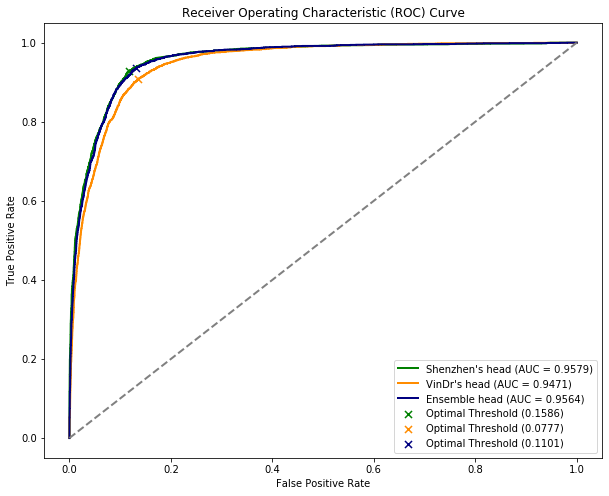

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
df = pd.read_csv("Ark6_swinL768_SIIM_Pneumothorax_ZeroShotPred.csv")
y_true = np.array(df['SIIMPTX'])
y_scores = np.array(df['Pneumothorax.1'])
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

y_scores2 = np.array(df['Pneumothorax.2'])
fpr2, tpr2, thresholds = roc_curve(y_true, y_scores2)
roc_auc2 = auc(fpr2, tpr2)
optimal_threshold_index2 = np.argmax(tpr2 - fpr2)
optimal_threshold2 = thresholds[optimal_threshold_index2]


y_scores3 = np.average((np.array(df['Pneumothorax.1']),np.array(df['Pneumothorax.2'])), axis = 0)
fpr3, tpr3,thresholds = roc_curve(y_true, y_scores3)
roc_auc3 = auc(fpr3, tpr3)
optimal_threshold_index3 = np.argmax(tpr3 - fpr3)
optimal_threshold3 = thresholds[optimal_threshold_index3]

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='green', lw=2, label='Shenzhen\'s head (AUC = {:.4f})'.format(roc_auc))
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label='VinDr\'s head (AUC = {:.4f})'.format(roc_auc2))
plt.plot(fpr3, tpr3, color='navy', lw=2, label='Ensemble head (AUC = {:.4f})'.format(roc_auc3))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], color='green', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold:.4f})')
plt.scatter(fpr2[optimal_threshold_index2], tpr2[optimal_threshold_index2], color='darkorange', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold2:.4f})')
plt.scatter(fpr3[optimal_threshold_index3], tpr3[optimal_threshold_index3], color='navy', s=50, marker='x', label=f'Optimal Threshold ({optimal_threshold3:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
